In [ ]:
!pip install PyWavelets


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, TimeDistributed
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from glob import glob
import seaborn as sns
from keras.constraints import MaxNorm
import pywt

# File upload for Colab
from google.colab import files

# Upload the datasets
print("Please upload 'raw_non_rand.csv', 'raw2.csv', 'raw3.csv', and 'raw4.csv'")
uploaded = files.upload()

# Accessing uploaded files
file1 = list(uploaded.keys())[0]  # raw_non_rand.csv
file2 = list(uploaded.keys())[1]  # raw2.csv
file3 = list(uploaded.keys())[2]  # raw3.csv
file4 = list(uploaded.keys())[3]  # raw4.csv

# Load datasets into pandas DataFrames
DATA = pd.read_csv(file1)
DATA2 = pd.read_csv(file2)
DATA3 = pd.read_csv(file3)
DATA4 = pd.read_csv(file4)


# Process the data
Data = DATA[['CH2', 'CH3', 'CH5', 'CH7', 'Direction']][4000:]
Data2 = DATA2[['CH2', 'CH3', 'CH5', 'CH7', 'Direction']][4000:]
Data3 = DATA3[['CH2', 'CH3', 'CH5', 'CH7', 'Direction']][4000:]
Data4 = DATA4[['CH2', 'CH3', 'CH5', 'CH7', 'Direction']][4000:]



# Display the first 5 rows of the processed data
print(Data.head())


Please upload 'raw_non_rand.csv', 'raw2.csv', 'raw3.csv', and 'raw4.csv'


Saving raw4.csv.zip to raw4.csv.zip
Saving raw3.csv.zip to raw3.csv.zip
Saving raw2.csv.zip to raw2.csv.zip
Saving raw_non_rand.csv.zip to raw_non_rand.csv.zip
               CH2          CH3           CH5          CH7 Direction
4000  20719.580078 -400000.0625  26592.449219  5225.899902      left
4001  20732.689453 -400000.0625  26608.900391  5245.589844      left
4002  20742.990234 -400000.0625  26620.060547  5256.560059      left
4003  20727.160156 -400000.0625  26604.800781  5242.729980      left
4004  20711.380859 -400000.0625  26588.589844  5229.040039      left


In [ ]:
import pandas as pd
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

# Function to design a Butterworth filter
def butter_filter(data, lowcut=None, highcut=None, fs=1000.0, order=5):
    nyquist = 0.5 * fs
    if lowcut and highcut:  # Bandpass filter
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
    elif lowcut:  # High-pass filter
        low = lowcut / nyquist
        b, a = butter(order, low, btype='high')
    elif highcut:  # Low-pass filter
        high = highcut / nyquist
        b, a = butter(order, high, btype='low')
    else:
        raise ValueError("Must specify either lowcut or highcut or both.")
    y = filtfilt(b, a, data)
    return y


# Function to process and normalize data
def process_and_normalize(data, fs=250.0, lowcut=0.1, highcut=40.0):


    # Apply lowpass filter
    data['CH2_lowpass'] = butter_filter(data['CH2'], highcut=highcut, fs=fs)
    data['CH7_lowpass'] = butter_filter(data['CH7'], highcut=highcut, fs=fs)

    # Apply highpass filter
    data['CH2_filtered'] = butter_filter(data['CH2_lowpass'], lowcut=lowcut, fs=fs)
    data['CH7_filtered'] = butter_filter(data['CH7_lowpass'], lowcut=lowcut, fs=fs)

    # Drop intermediate columns
    data = data.drop(columns=['CH2_lowpass', 'CH7_lowpass', 'CH2', 'CH7'])

    # Initialize the scaler
    scaler = StandardScaler()

    # Standardize 'CH2_filtered' and 'CH7_filtered'
    data[['CH2_filtered', 'CH7_filtered']] = scaler.fit_transform(data[['CH2_filtered', 'CH7_filtered']])

    return data

# Example usage with multiple datasets
dataframes = [
    #Data,  # Uncomment if this dataframe is available
    Data2,
    Data3,
    Data4
]

# Process each dataframe individually
processed_dataframes = [process_and_normalize(df) for df in dataframes]

# Combine all processed dataframes vertically
data = pd.concat(processed_dataframes, ignore_index=True)




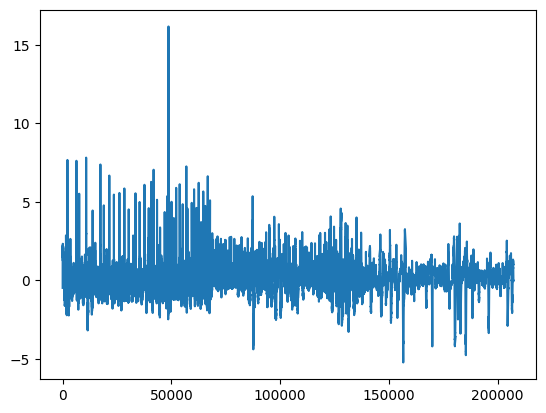

In [ ]:
plt.plot(data['CH2_filtered'])

(207300, 5)
(207300, 5)


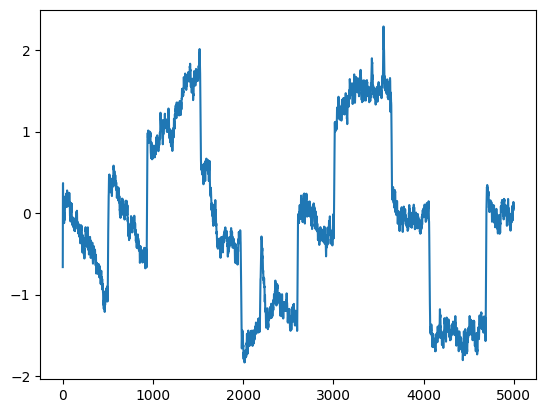

In [ ]:

df = data.copy()

# Drop intermediate columns
#df = df.drop(columns=['CH2_lowpass', 'CH7_lowpass','CH2','CH7'])

firs = 0
plt.plot(df['CH7_filtered'][firs:firs+5000])
print(df.shape)
print(data.shape)

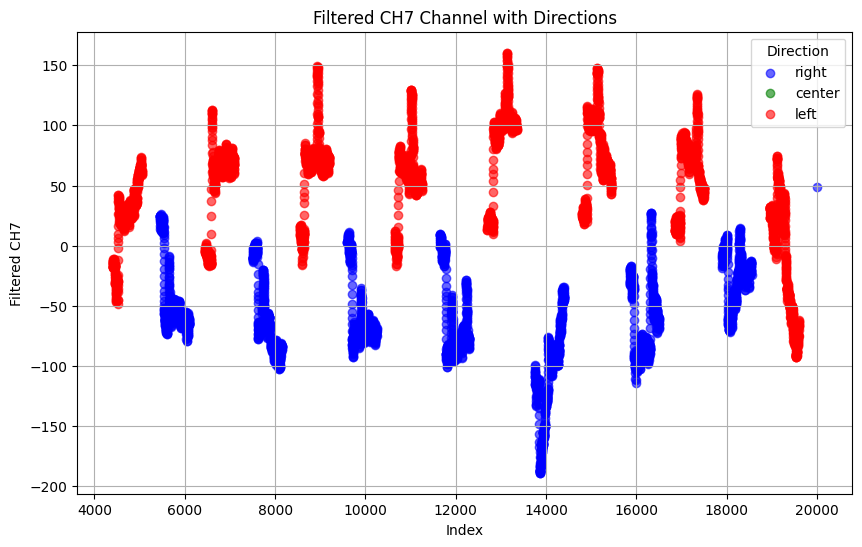

In [ ]:
# Define the range of indexes to look at
start_index = 0  # Replace with your desired start index
end_index = start_index + 20000  # Replace with your desired end index

# Plotting the filtered CH7 data as a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
directions = df['Direction'].unique()  # Get unique directions from the dataset
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for different directions
for df in [Data, Data2, Data3, Data4]:
    if 'Direction' in df.columns:
       df['Direction'] = df['Direction'].replace({'center': 'blink'})

for i, direction in enumerate(directions):
    # Filter data for the current direction within the index range
    direction_data = df[(df['Direction'] == direction) & (df.index >= start_index) & (df.index <= end_index)]
    plt.scatter(direction_data.index, direction_data['CH7_filtered'], label=direction, color=colors[i % len(colors)], alpha=0.6)

# Set plot labels and title
plt.xlabel('Index')
plt.ylabel('Filtered CH7')
plt.title('Filtered CH7 Channel with Directions')
plt.legend(title='Direction')  # Add a legend
plt.grid(True)  # Add a grid
plt.show()



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

point = 0.5

def classify_direction(value):
    if value < -point:
        return 'right'
    elif value > point:
        return 'left'
    else:
        return 'blink'

# Apply the classification function to the 'CH7_filtered' column
df['Predicted_Direction'] = df['CH7_filtered'].apply(classify_direction)

# Generate the classification report
report = classification_report(df['Direction'], df['Predicted_Direction'], target_names=['left', 'right', 'blink'])
print(report)

              precision    recall  f1-score   support

        left       0.59      0.01      0.03     26350
       right       0.54      0.85      0.66     21450
       blink       0.50      0.83      0.62     21350

    accuracy                           0.52     69150
   macro avg       0.55      0.56      0.44     69150
weighted avg       0.55      0.52      0.41     69150



In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the target variable
label_encoder = LabelEncoder()
df['Direction_encoded'] = label_encoder.fit_transform(df['Direction'])

# Features and target variablek
X = df[['CH2_filtered', 'CH7_filtered']]
y = df['Direction_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)


In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
